<a href="https://colab.research.google.com/github/adag21044/PoliticalTweetAnalyzer/blob/main/PoliticalTweetAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

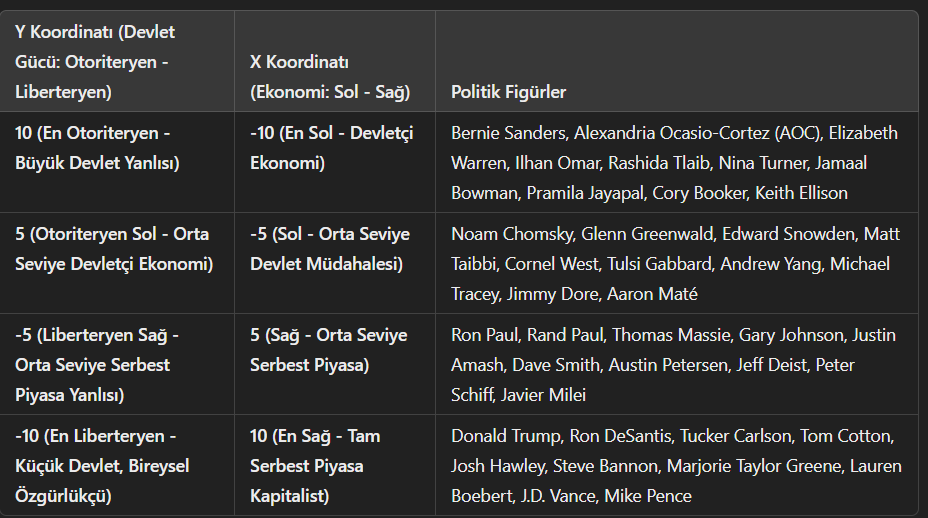

In [1]:
# =======================================
# ✅ IMPORT NECESSARY LIBRARIES
# =======================================

import re # For regular expressions (used in text cleaning)
import os # For file path handling and OS-level operations
import numpy as np # For numerical operations and arrays
import pandas as pd # For handling and manipulating tabular data - Tabular data is data that is organized in rows and columns, similar to a spreadsheet or a database table.
import torch # For working with PyTorch tensors and models
from tqdm import tqdm # For displaying progress bars during loops
from transformers import AutoTokenizer, AutoModel # For loading pretrained BERT models and tokenizers
from sklearn.neural_network import MLPRegressor # For training a neural network regression model
from sklearn.preprocessing import StandardScaler # For scaling input features to improve model performance
import matplotlib.pyplot as plt # For visualizing results on the political compass

In [2]:
# =======================================
# ✅ 1️⃣ SYNTHETIC POLITICAL DATASET
# =======================================

# Sample ideological tweets categorized by compass quadrant
tweets_data = {
    "authoritarian_left": [
        "The government must regulate businesses for fairness.",
        "We need higher taxes on the rich for wealth redistribution.",
        "Public healthcare is a human right, not a privilege.",
        "Strong government policies will protect the working class."
    ],
    "libertarian_left": [
        "People should be free to make their own life choices.",
        "The government should not interfere in personal matters.",
        "Decentralization of power is key to real freedom.",
        "We need a social safety net, but with personal choice."
    ],
    "authoritarian_right": [
        "Strong borders make a strong nation!",
        "Law and order must be strictly enforced.",
        "Traditional values should be the foundation of our society.",
        "Military strength is necessary for national security."
    ],
    "libertarian_right": [
        "The free market is the best path to economic growth.",
        "Less government regulation means more innovation.",
        "People should have full control over their private property.",
        "Taxation is theft! Government should be as small as possible."
    ]
}

In [3]:
# =======================================
# ✅ 2️⃣ TEXT CLEANING FUNCTION
# =======================================

# Preprocessing tweets: lowercasing, URL, mention, hashtag, and punctuation removal
def preprocess_tweet(tweet):
    if pd.isna(tweet):  #Check is this value missing?
        return ""
    tweet = tweet.lower() # Convert all characters in the tweet to lowercase for consistency
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet) # Remove URLs
    tweet = re.sub(r"@\w+|#", "", tweet) # Remove mentions and hashtags
    tweet = re.sub(r"[^\w\s]", "", tweet) # Remove punctuation
    return tweet

# Apply preprocessing to each tweet
for category in tweets_data:
    tweets_data[category] = [preprocess_tweet(tweet) for tweet in tweets_data[category]]

In [4]:
# ====================================
# ✅ 3️⃣ LOAD TRANSFORMER MODEL (BERT)
# ====================================

# Load tokenizer and model (RoBERTa pretrained on Twitter data)
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base") # Converts text into model-readable token IDs
bert_model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base") # Loads the pretrained BERT model

# Function to compute mean-pooled BERT embeddings from tweet text
def get_bert_embedding(tweet):
    tokens = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True, max_length=50) # Tokenizes the tweet and converts it to a PyTorch tensor with padding and truncation

    # Disables gradient calculation and gets BERT model output for the input tokens
    with torch.no_grad():
        outputs = bert_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).numpy().flatten()  # Applies mean pooling to BERT output and returns it as a flattened NumPy vector

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [5]:
# =======================================
# ✅ 4️⃣ MANUALLY LABELED POLITICAL TWEETS
# =======================================
# Simulated tweet data with associated compass coordinates
datasets = {
    "(-10,10)": pd.DataFrame({"text": [
        "Healthcare is a human right.",
        "We must tax billionaires fairly.",
        "Workers deserve a living wage.",
        "Climate change is the greatest threat to humanity."
    ]}),
    "(-5,5)": pd.DataFrame({"text": [
        "The Green New Deal is essential for our future.",
        "Public housing must be expanded and funded.",
        "Every American deserves dignified work and wages.",
        "We must challenge corporate power in Washington."
    ]}),
    "(5,-5)": pd.DataFrame({"text": [
        "The government should be as small as possible.",
        "End the Fed and return fiscal responsibility.",
        "Taxation should be minimal and transparent.",
        "Personal freedoms are the foundation of a healthy society.",
        "Thank you for your leadership @realDonaldTrump.",
        "President Trump's commitment to heightened border security is making America safer.",
        "President Trump IS the President of Peace.",
        "Where Joe Biden failed, President Trump will succeed."
    ]}),
    "(10,-10)": pd.DataFrame({"text": [
        "We will build the wall and secure our borders.",
        "Make America Great Again!",
        "America First, always.",
        "Our military is stronger than ever before."
    ]})
}

In [7]:
# =======================================
# ✅ 5️⃣ LOAD REAL TWEET DATASETS
# =======================================

# Combine progressive tweet datasets (AOC + Bernie)
df_bernie = pd.read_csv("/content/Bernie_tweets.csv", on_bad_lines="skip")
df_aoc = pd.read_csv("/content/aoc_tweets.csv", on_bad_lines="skip")
combined_left = pd.concat([df_bernie, df_aoc], ignore_index=True)


real_datasets = {
    "(-10,10)": combined_left,
    "(10,-10)": pd.read_csv("/content/trumptweets.csv", on_bad_lines="skip")
}


In [8]:
# ====================================
# ✅ 6️⃣ DEMOCRAT - REPUBLICAN DATASET
# ====================================

df_parties = pd.read_csv("/content/Democrat Vs. Republican Tweets.csv")
democrat_tweets = df_parties[df_parties["Party"] == "Democrat"]["Tweet"].tolist()
republican_tweets = df_parties[df_parties["Party"] == "Republican"]["Tweet"].tolist()

In [9]:
# =======================================
# ✅ 7️⃣ EMBEDDING + LABEL ASSIGNMENT
# =======================================

# Mapping of political compass label strings to coordinate tuples
point_map = {
    "(-10,10)": (-10, 10), # Authoritarian Left
    "(-5,5)": (-5, 5),     # Slightly Authoritarian Left
    "(5,-5)": (5, -5),     # Slightly Libertarian Right
    "(10,-10)": (10, -10)  # Libertarian Right
}

# Initialize feature (X) and label (y) lists
X, y = [], []

# ▶️ Process Democrat tweets and label them as (-5,5)
for tweet in tqdm(democrat_tweets, desc="Embedding Democrat (-5,5)"):
    X.append(get_bert_embedding(preprocess_tweet(tweet)))  # Extract BERT embedding
    y.append((-5,5)) # Assign political compass coordinate as label

# ▶️ Process Republican tweets and label them as (5,-5)
for tweet in tqdm(republican_tweets, desc="Embedding Republican (5,-5)"):
    X.append(get_bert_embedding(preprocess_tweet(tweet))) # Extract BERT embedding
    y.append((5,-5)) # Assign political compass coordinate as label

# Embed real tweets from known figures (e.g. Trump, AOC, Bernie Sanders)
for point, df in real_datasets.items():
    coords = point_map[point] # Get compass coordinate from string
    # Try to find the tweet text column (name may vary)
    tweets_column = next((col for col in df.columns if col in ["text", "Tweet", "body", "content"]), None)
    if tweets_column is None:
        raise ValueError("Expected text column not found in dataset.")
    for tweet in tqdm(df[tweets_column].tolist(), desc=f"Embedding {point}"):
        X.append(get_bert_embedding(preprocess_tweet(tweet)))
        y.append(coords) # Assign the corresponding coordinate


Embedding (10,-10): 100%|██████████| 41122/41122 [1:56:40<00:00,  5.87it/s]


Synthetic Data

In [11]:
# Embed additional synthetic tweet data with known (x,y) labels
# List of synthetic data file paths
synthetic_files = [
    "/content/synthetic data 1.csv",
    "/content/synthetic data 2.csv",
    "/content/synthetic data 3.csv",
    "/content/synthetic data 4.csv",
    "/content/synthetic data 5.csv",
    "/content/synthetic data 6.csv",
    "/content/synthetic data 7.csv",
    "/content/synthetic data 8.csv",
    "/content/synthetic data 9.csv",
    "/content/synthetic data 10.csv"
]

# Process each synthetic file
for file_path in synthetic_files:
    print(f"Loading {file_path}")
    synthetic_df = pd.read_csv(file_path)
    for _, row in tqdm(synthetic_df.iterrows(), total=len(synthetic_df), desc=f"Embedding {os.path.basename(file_path)}"):
        text = preprocess_tweet(row["text"])
        embedding = get_bert_embedding(text)
        X.append(embedding)
        y.append((row["x"], row["y"]))


Loading /content/synthetic data 1.csv


Embedding synthetic data 1.csv: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Loading /content/synthetic data 2.csv


Embedding synthetic data 2.csv: 100%|██████████| 441/441 [00:50<00:00,  8.78it/s]


Loading /content/synthetic data 3.csv


Embedding synthetic data 3.csv: 100%|██████████| 45/45 [00:05<00:00,  8.25it/s]


Loading /content/synthetic data 4.csv


Embedding synthetic data 4.csv: 100%|██████████| 50/50 [00:04<00:00, 10.13it/s]


Loading /content/synthetic data 5.csv


Embedding synthetic data 5.csv: 100%|██████████| 50/50 [00:05<00:00,  9.79it/s]


Loading /content/synthetic data 6.csv


Embedding synthetic data 6.csv: 100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


Loading /content/synthetic data 7.csv


Embedding synthetic data 7.csv: 100%|██████████| 50/50 [00:04<00:00, 10.63it/s]


Loading /content/synthetic data 8.csv


Embedding synthetic data 8.csv: 100%|██████████| 50/50 [00:05<00:00,  8.61it/s]


Loading /content/synthetic data 9.csv


Embedding synthetic data 9.csv: 100%|██████████| 50/50 [00:04<00:00, 10.05it/s]


Loading /content/synthetic data 10.csv


Embedding synthetic data 10.csv: 100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


In [12]:
# =======================================
# ✅ 8️⃣ TRAIN MLP REGRESSOR
# =======================================

# Convert the list of embeddings (X) and coordinates (y) into NumPy arrays
# These are standard data formats for machine learning
X = np.array(X) # Features (tweet embeddings)
y = np.array(y) # Labels (political compass positions)

# Scale the input features so all values are on a similar scale (mean=0, std=1)
# This helps the model learn better and faster
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Create a machine learning model called MLPRegressor (a type of neural network)
# It will learn to predict political compass positions (x, y) from tweet embeddings
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128), # Two hidden layers with 256 and 128 neurons
    max_iter=1000,                 # Train for up to 1000 cycles
    early_stopping=True,           # Stop early if model stops improving
    n_iter_no_change=10,           # Stop if no improvement for 10 rounds
    validation_fraction=0.1,       # Use 10% of data to validate while training
    random_state=42,               # Seed for consistent results
    verbose=True                   # Show training progress
)

# Train (fit) the model using the input features and known compass coordinates
mlp.fit(X, y)

print("✅ Model retrained with full dataset!")

Iteration 1, loss = 9.86509066
Validation score: 0.558449
Iteration 2, loss = 7.98470861
Validation score: 0.584873
Iteration 3, loss = 7.15633625
Validation score: 0.586228
Iteration 4, loss = 6.49986152
Validation score: 0.594195
Iteration 5, loss = 5.92439423
Validation score: 0.599008
Iteration 6, loss = 5.38484620
Validation score: 0.591991
Iteration 7, loss = 4.89106778
Validation score: 0.592013
Iteration 8, loss = 4.44160918
Validation score: 0.585412
Iteration 9, loss = 4.01098547
Validation score: 0.575356
Iteration 10, loss = 3.62793617
Validation score: 0.566042
Iteration 11, loss = 3.32020497
Validation score: 0.560889
Iteration 12, loss = 3.03399245
Validation score: 0.555655
Iteration 13, loss = 2.78084010
Validation score: 0.548286
Iteration 14, loss = 2.53589913
Validation score: 0.532165
Iteration 15, loss = 2.34959333
Validation score: 0.530841
Iteration 16, loss = 2.16097067
Validation score: 0.530195
Validation score did not improve more than tol=0.000100 for 10 co

In [13]:
# =======================================
# ✅ 9️⃣ PREDICT USER TWEET POSITION
# =======================================

# This is the tweet we want to analyze (user input)
my_tweet = "The government is getting too big and controlling everyt
ing."

# Clean the tweet by removing links, symbols, and making it lowercase
cleaned_tweet = preprocess_tweet(my_tweet)

# Convert the cleaned tweet into a numerical vector using BERT
my_embedding = get_bert_embedding(cleaned_tweet).reshape(1, -1)

# Apply the same scaling we used during training to normalize the new input
my_embedding = scaler.transform(my_embedding)

# Use the trained model to predict the tweet's position on the political compass
predicted_point = mlp.predict(my_embedding)[0]

# Show the result as (x, y) coordinates on the political map
print("Predicted compass point:", predicted_point)

Predicted compass point: [ 7.1677165 -6.510699 ]


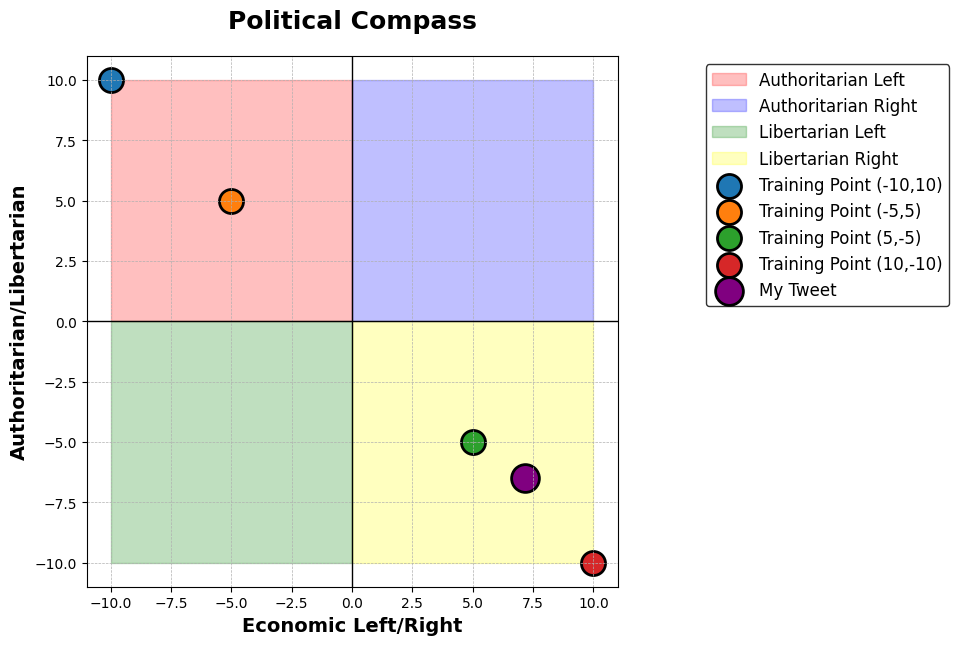

In [14]:
# =======================================
# ✅ 🔟 VISUALIZE ON POLITICAL COMPASS
# =======================================

# Create a new square figure for the political compass plot
plt.figure(figsize=(10, 10))

# Draw horizontal and vertical lines at the center (0,0)
plt.axhline(0, color="black", linewidth=1) # Horizontal line (authoritarian/libertarian divider)
plt.axvline(0, color="black", linewidth=1) # Vertical line (left/right economic divider)

# Color each quadrant of the compass to show political zones
plt.fill_between([-10, 0], 0, 10, color="red", alpha=0.25, label="Authoritarian Left")
plt.fill_between([0, 10], 0, 10, color="blue", alpha=0.25, label="Authoritarian Right")
plt.fill_between([-10, 0], -10, 0, color="green", alpha=0.25, label="Libertarian Left")
plt.fill_between([0, 10], -10, 0, color="yellow", alpha=0.25, label="Libertarian Right")

# Set visible area of the graph
plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.gca().set_aspect('equal', adjustable='box')

# Label the axes
plt.xlabel("Economic Left/Right", fontsize=14, fontweight="bold")
plt.ylabel("Authoritarian/Libertarian", fontsize=14, fontweight="bold")
plt.title("Political Compass", fontsize=18, fontweight="bold", pad=20)

# Plot known training points used in the model (anchors)
for point, (x, y_) in point_map.items():
    plt.scatter(x, y_, s=300, label=f"Training Point {point}", edgecolors="black", linewidth=2)

# Plot the predicted position of the user's tweet on the compass
plt.scatter(predicted_point[0], predicted_point[1], s=400, color="purple", label="My Tweet", edgecolors="black", linewidth=2)

# Show the legend (key) outside the main plot
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=12, frameon=True, edgecolor="black")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

**Save Datas**

In [15]:
import joblib

# =======================================
# ✅ SAVE MODEL AND SCALER
# =======================================

joblib.dump(mlp, "mlp_model.joblib")
joblib.dump(scaler, "scaler_model.joblib")
joblib.dump(point_map, "point_map.pkl")

print("✅ Model and Scaler saved!")


✅ Model and Scaler saved!


**Load Datas**

In [ ]:
import joblib # A library used to save and load machine learning models

# ===========================
# ✅ Model and Scaler Load
# ===========================

# Save the trained neural network model to a file
mlp = joblib.load("mlp_model.joblib")

# Save the scaler (used to normalize inputs) to a file
scaler = joblib.load("scaler_model.joblib")

# Save the compass point map (used for visualization)
point_map_loaded = joblib.load("point_map.pkl")

# Predict again (e.g. for deployment)
my_tweet = "The government is getting too big and controlling everything."
cleaned_tweet = preprocess_tweet(my_tweet)
my_embedding = get_bert_embedding(cleaned_tweet).reshape(1, -1)
my_embedding = scaler.transform(my_embedding)
predicted_point = mlp.predict(my_embedding)[0]
print("Predicted compass point:", predicted_point)

Tahmin edilen pusula noktası: [ 0.36613983 -0.37392962]


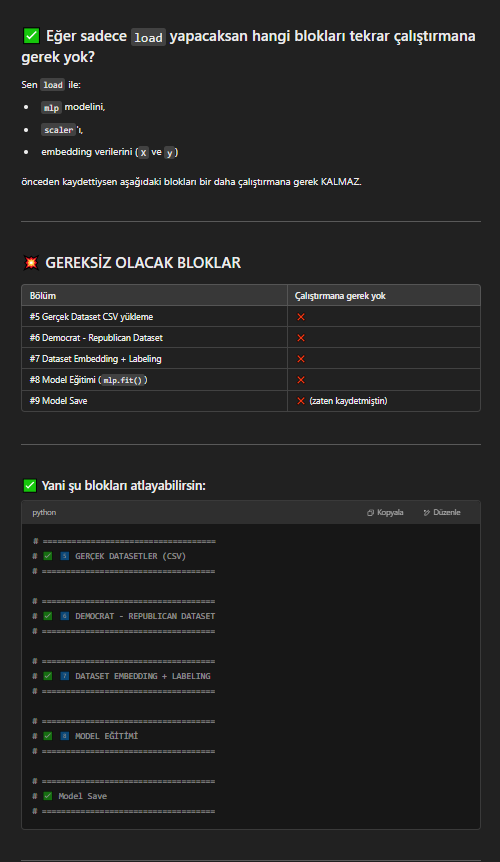
